# CTA 5.0 - Optimization 2.0

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time

import pandas as pd
import numpy as np

from cvx.simulator import FuturesBuilder
from cvx.simulator import interpolate


from tinycta.linalg import *
from tinycta.signal import *

In [2]:
# Load prices
prices = pd.read_csv("data/Prices_hashed.csv", index_col=0, parse_dates=True)

# interpolate the prices
prices = prices.apply(interpolate)

In [3]:
from ipywidgets import Label, HBox, VBox, IntSlider, FloatSlider

fast = IntSlider(min=4, max=192, step=4, value=32)
slow = IntSlider(min=4, max=192, step=4, value=96)
vola = IntSlider(min=4, max=192, step=4, value=32)
winsor = FloatSlider(min=1.0, max=6.0, step=0.1, value=4.2)
corr = IntSlider(min=50, max=500, step=10, value=200)
shrinkage = FloatSlider(min=0.0, max=1.0, step=0.05, value=0.5)
left_box = VBox([Label("Fast Moving Average"), 
                 Label("Slow Moving Average"), 
                 Label("Volatility"), 
                 Label("Winsorizing"),
                 Label("Correlation"),
                 Label("Shrinkage")])

right_box = VBox([fast, slow, vola, winsor, corr, shrinkage])
HBox([left_box, right_box])

In [10]:
T = time.time()
correlation = corr.value

returns_adj = prices.apply(returns_adjust, com=vola.value, clip=winsor.value)

# DCC by Engle
cor = returns_adj.ewm(com=correlation, min_periods=correlation).corr()

mu = np.tanh(returns_adj.cumsum().apply(osc)).values
vo = prices.pct_change().ewm(com=vola.value, min_periods=vola.value).std().values

builder = FuturesBuilder(prices=prices, aum=1e8)

for n, (t, state) in enumerate(builder):
    mask = state.mask
    matrix = shrink2id(cor.loc[t[-1]].values, lamb=shrinkage.value)[mask, :][:, mask]
    expected_mu = np.nan_to_num(mu[n][mask])
    expected_vo = np.nan_to_num(vo[n][mask])
    risk_position = solve(matrix, expected_mu) / inv_a_norm(expected_mu, matrix)
    builder.cashposition = 1e6*risk_position / expected_vo

portfolio = builder.build()
print(time.time()-T)


/Users/a13069q/github/cs/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


13.987380981445312


# Conclusions
* Dramatic relativ improvements observable despite using the same signals as in previous Experiment.
* Main difference here is to take advantage of cross-correlations in the risk measurement.
* Possible to add constraints on individual assets or groups of them.
* Possible to reflect trading costs in objective with regularization terms (Ridge, Lars, Elastic Nets, ...)

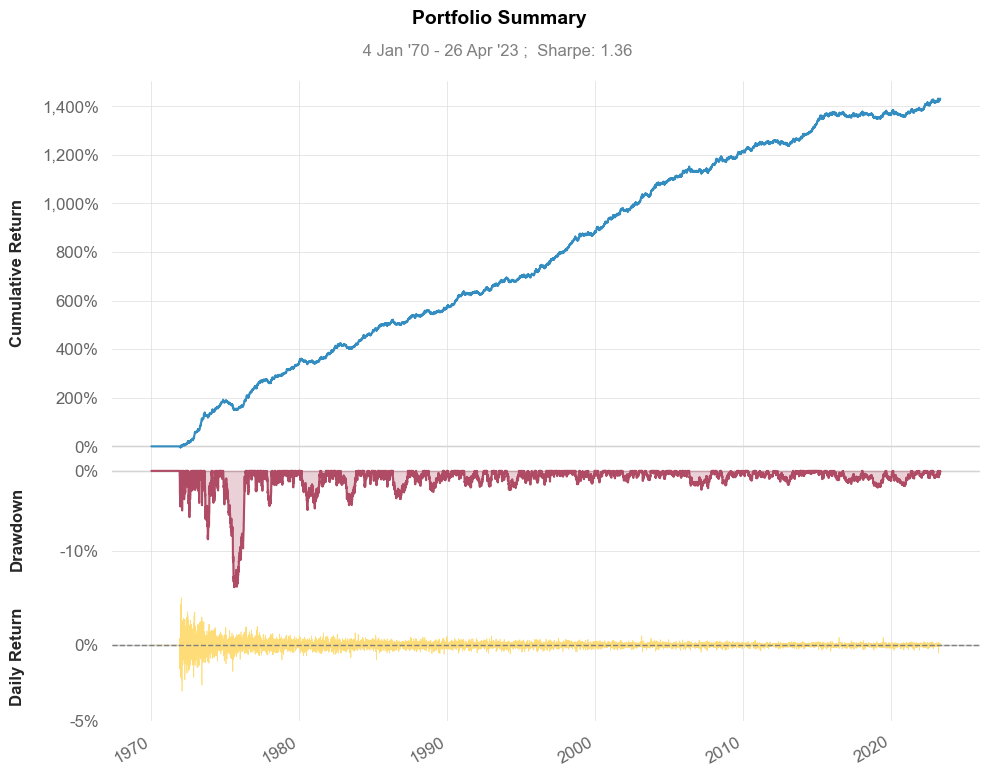

In [11]:
portfolio.snapshot()

In [9]:
pd.set_option('display.precision', 2)
portfolio.metrics()

                    Strategy
------------------  ----------
Start Period        1970-01-05
End Period          2023-04-26
Risk-Free Rate      0.0%
Time in Market      95.0%

Cumulative Return   0.0%
CAGR﹪              0.0%

Sharpe              1.41
Prob. Sharpe Ratio  100.0%
Sortino             2.09
Sortino/√2          1.48
Omega               1.27

Max Drawdown        -0.0%
Longest DD Days     584

Gain/Pain Ratio     0.27
Gain/Pain (1M)      1.79

Payoff Ratio        1.03
Profit Factor       1.27
Common Sense Ratio  1.37
CPC Index           0.72
Tail Ratio          1.08
Outlier Win Ratio   3.36
Outlier Loss Ratio  3.27

MTD                 0.0%
3M                  0.0%
6M                  0.0%
YTD                 0.0%
1Y                  0.0%
3Y (ann.)           0.0%
5Y (ann.)           0.0%
10Y (ann.)          0.0%
All-time (ann.)     0.0%

Avg. Drawdown       -0.0%
Avg. Drawdown Days  25
Recovery Factor     33.57
Ulcer Index         0.0
Serenity Index      9.47
